# Improt Library

In [24]:
import time
import folium
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
from datetime import datetime
from tqdm import tqdm_notebook

import geopy
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

import plotly.express as px
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, LabelBinarizer
from sklearn_pandas import DataFrameMapper
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score

from scipy import stats


# Data & Preprocessing Data

In [25]:
# Load the uploaded Excel file
file_path = '/Users/mac/Documents/SkripsiAcuan/SKRIPSI/data.csv'
df = pd.read_csv(file_path)

# Display the data
df


day  year  month  date   time              address     district  \
0       Monday  2018      1     1   0:15       urip sumuharjo  panakkukang   
1       Monday  2018      1     1   0:30  sungai saddang baru     makassar   
2       Monday  2018      1     1  19:45            boulevard  panakkukang   
3       Monday  2018      1     1  20:10       urip sumuharjo  panakkukang   
4       Monday  2018      1     1  20:30              tinumbu     bontoala   
...        ...   ...    ...   ...    ...                  ...          ...   
3533  Saturday  2020     10    10   7:00          cendrawasih     mamajang   
3534    Sunday  2020     10    11  11:30  metro tanjung bunga     tamalate   
3535    Friday  2020     10     9  14:00          daeng regge        tallo   
3536  Saturday  2020     10    10  18:30  metro tanjung bunga     tamalate   
3537    Sunday  2020     10    11   1:15        g. batu putih     makassar   

     accident_types suspect_vehicle victim_vehicle  
0                 T              R4            NOV  
1                TL              R2             R2  
2                TL              R4             R4  
3                TK              R2             R2  
4                TM              R2            NOV  
...             ...             ...            ...  
3533              T              R2            NOV  
3534             OC              R2            NOV  
3535              T              R2            NOV  
3536             OC              R2            NOV  
3537             TK              R4             R2  

[3538 rows x 10 columns]

Nilai yang hilang pada kolom year, month, dan date:
year     0
month    0
date     0
dtype: int64
Baris dengan nilai datetime yang tidak valid (NaT): 0


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1059/981205005.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_2018, x='accident_types', palette='viridis', alpha=0.7, order=all_accident_types)


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1059/981205005.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_2018, x='suspect_vehicle', palette='Set2', alpha=0.7, order=all_suspect_vehicle)
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1059/981205005.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_2018, x='victim_vehicle', palette='Set1', alpha=0.7, order=all_victim_vehicle)
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1059/981205005.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



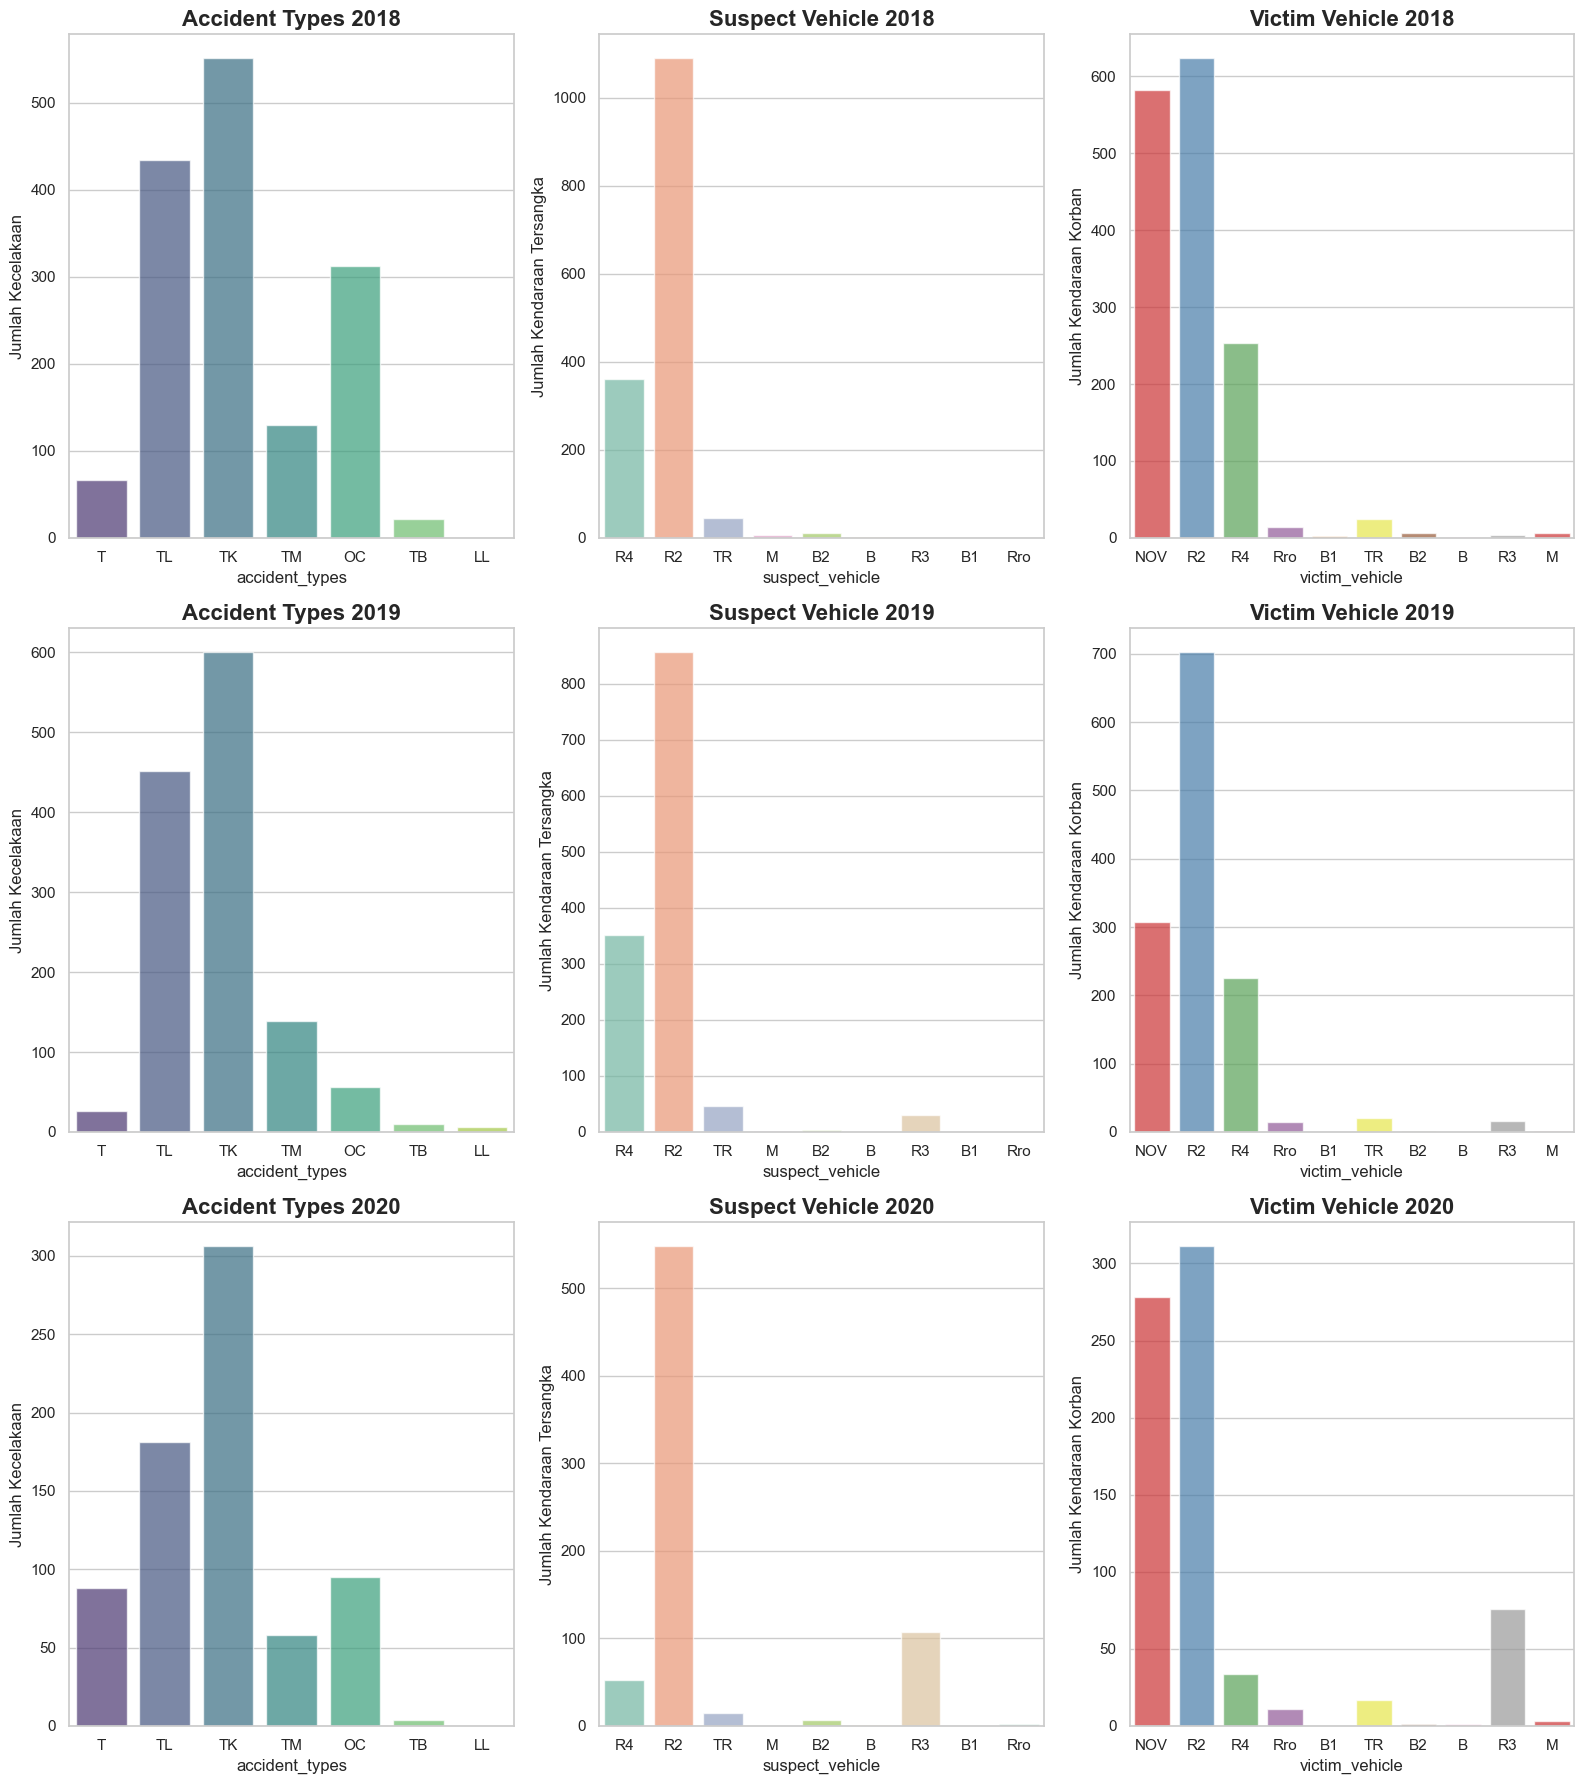

In [27]:
# Mengecek nilai yang hilang pada kolom 'year', 'month', dan 'date'
print("Nilai yang hilang pada kolom year, month, dan date:")
print(df[['year', 'month', 'date']].isna().sum())

# Menghapus baris dengan nilai yang hilang atau tidak valid di 'year', 'month', atau 'date'
df = df[(df['year'].notna()) & (df['month'].notna()) & (df['date'].notna())]
df = df[(df['year'] > 0) & (df['month'] > 0) & (df['month'] <= 12) & (df['date'] > 0) & (df['date'] <= 31)]

# Membuat kolom datetime dengan menggabungkan tahun, bulan, dan tanggal menjadi string
df['datetime_str'] = df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2) + '-' + df['date'].astype(str).str.zfill(2)

# Mengonversi string datetime menjadi objek datetime
df['datetime'] = pd.to_datetime(df['datetime_str'], errors='coerce')

# Mengecek ada tidaknya nilai datetime yang tidak valid (NaT artinya Not a Time)
print(f"Baris dengan nilai datetime yang tidak valid (NaT): {df[df['datetime'].isna()].shape[0]}")

# Mengatur gaya visual Seaborn agar lebih menarik dan jelas
sns.set(style="whitegrid")
plt.figure(figsize=(16, 18))

# Menyaring data berdasarkan tahun 2018, 2019, dan 2020
df_2018 = df[df['year'] == 2018]
df_2019 = df[df['year'] == 2019]
df_2020 = df[df['year'] == 2020]

# Pastikan bahwa setiap kategori untuk 'accident_types', 'suspect_vehicle', dan 'victim_vehicle' terdaftar
all_accident_types = df['accident_types'].unique()
all_suspect_vehicle = df['suspect_vehicle'].unique()
all_victim_vehicle = df['victim_vehicle'].unique()

# Konversi kolom menjadi kategori dengan seluruh kemungkinan nilai
df['accident_types'] = pd.Categorical(df['accident_types'], categories=all_accident_types)
df['suspect_vehicle'] = pd.Categorical(df['suspect_vehicle'], categories=all_suspect_vehicle)
df['victim_vehicle'] = pd.Categorical(df['victim_vehicle'], categories=all_victim_vehicle)

# Plot untuk 'accident_types' (Jenis Kecelakaan) untuk 2018
plt.subplot(3, 3, 1)  # 3 baris, 3 kolom, plot ke-1
sns.countplot(data=df_2018, x='accident_types', palette='viridis', alpha=0.7, order=all_accident_types)
plt.title('Accident Types 2018', fontsize=16, fontweight='bold')
plt.xlabel('accident_types', fontsize=12)
plt.ylabel('Jumlah Kecelakaan', fontsize=12)

# Plot untuk 'suspect_vehicle' (Kendaraan Tersangka) untuk 2018
plt.subplot(3, 3, 2)  # 3 baris, 3 kolom, plot ke-2
sns.countplot(data=df_2018, x='suspect_vehicle', palette='Set2', alpha=0.7, order=all_suspect_vehicle)
plt.title('Suspect Vehicle 2018', fontsize=16, fontweight='bold')
plt.xlabel('suspect_vehicle', fontsize=12)
plt.ylabel('Jumlah Kendaraan Tersangka', fontsize=12)

# Plot untuk 'victim_vehicle' (Kendaraan Korban) untuk 2018
plt.subplot(3, 3, 3)  # 3 baris, 3 kolom, plot ke-3
sns.countplot(data=df_2018, x='victim_vehicle', palette='Set1', alpha=0.7, order=all_victim_vehicle)
plt.title('Victim Vehicle 2018', fontsize=16, fontweight='bold')
plt.xlabel('victim_vehicle', fontsize=12)
plt.ylabel('Jumlah Kendaraan Korban', fontsize=12)

# Plot untuk 'accident_types' (Jenis Kecelakaan) untuk 2019
plt.subplot(3, 3, 4)  # 3 baris, 3 kolom, plot ke-4
sns.countplot(data=df_2019, x='accident_types', palette='viridis', alpha=0.7, order=all_accident_types)
plt.title('Accident Types 2019', fontsize=16, fontweight='bold')
plt.xlabel('accident_types', fontsize=12)
plt.ylabel('Jumlah Kecelakaan', fontsize=12)

# Plot untuk 'suspect_vehicle' (Kendaraan Tersangka) untuk 2019
plt.subplot(3, 3, 5)  # 3 baris, 3 kolom, plot ke-5
sns.countplot(data=df_2019, x='suspect_vehicle', palette='Set2', alpha=0.7, order=all_suspect_vehicle)
plt.title('Suspect Vehicle 2019', fontsize=16, fontweight='bold')
plt.xlabel('suspect_vehicle', fontsize=12)
plt.ylabel('Jumlah Kendaraan Tersangka', fontsize=12)

# Plot untuk 'victim_vehicle' (Kendaraan Korban) untuk 2019
plt.subplot(3, 3, 6)  # 3 baris, 3 kolom, plot ke-6
sns.countplot(data=df_2019, x='victim_vehicle', palette='Set1', alpha=0.7, order=all_victim_vehicle)
plt.title('Victim Vehicle 2019', fontsize=16, fontweight='bold')
plt.xlabel('victim_vehicle', fontsize=12)
plt.ylabel('Jumlah Kendaraan Korban', fontsize=12)

# Plot untuk 'accident_types' (Jenis Kecelakaan) untuk 2020
plt.subplot(3, 3, 7)  # 3 baris, 3 kolom, plot ke-7
sns.countplot(data=df_2020, x='accident_types', palette='viridis', alpha=0.7, order=all_accident_types)
plt.title('Accident Types 2020', fontsize=16, fontweight='bold')
plt.xlabel('accident_types', fontsize=12)
plt.ylabel('Jumlah Kecelakaan', fontsize=12)

# Plot untuk 'suspect_vehicle' (Kendaraan Tersangka) untuk 2020
plt.subplot(3, 3, 8)  # 3 baris, 3 kolom, plot ke-8
sns.countplot(data=df_2020, x='suspect_vehicle', palette='Set2', alpha=0.7, order=all_suspect_vehicle)
plt.title('Suspect Vehicle 2020', fontsize=16, fontweight='bold')
plt.xlabel('suspect_vehicle', fontsize=12)
plt.ylabel('Jumlah Kendaraan Tersangka', fontsize=12)

# Plot untuk 'victim_vehicle' (Kendaraan Korban) untuk 2020
plt.subplot(3, 3, 9)  # 3 baris, 3 kolom, plot ke-9
sns.countplot(data=df_2020, x='victim_vehicle', palette='Set1', alpha=0.7, order=all_victim_vehicle)
plt.title('Victim Vehicle 2020', fontsize=16, fontweight='bold')
plt.xlabel('victim_vehicle', fontsize=12)
plt.ylabel('Jumlah Kendaraan Korban', fontsize=12)

# Menampilkan semua plot
plt.tight_layout()
plt.show()


In [3]:
df["address"] = df["address"].map(lambda x: str(x).strip().lower())
df["district"] = df["district"].map(lambda x: str(x).strip().lower())
df.head()

day  year  month  date   time              address     district  \
0  Monday  2018      1     1   0:15       urip sumuharjo  panakkukang   
1  Monday  2018      1     1   0:30  sungai saddang baru     makassar   
2  Monday  2018      1     1  19:45            boulevard  panakkukang   
3  Monday  2018      1     1  20:10       urip sumuharjo  panakkukang   
4  Monday  2018      1     1  20:30              tinumbu     bontoala   

  accident_types suspect_vehicle victim_vehicle  
0              T              R4            NOV  
1             TL              R2             R2  
2             TL              R4             R4  
3             TK              R2             R2  
4             TM              R2            NOV

In [4]:
df[df.isna().any(axis=1)]

Empty DataFrame
Columns: [day, year, month, date, time, address, district, accident_types, suspect_vehicle, victim_vehicle]
Index: []

In [5]:
df = df.replace('NaN', np.nan)
df = df.dropna()
print(df.shape)

(3538, 10)


In [6]:
location_df = df[["address", "district"]].copy()
location_df = location_df.drop_duplicates(subset=['address', 'district'])
location_df.reset_index(drop=True, inplace=True)
print(location_df.shape)
location_df.head()

(554, 2)


address     district
0       urip sumuharjo  panakkukang
1  sungai saddang baru     makassar
2            boulevard  panakkukang
3              tinumbu     bontoala
4             kecaping     manggala

In [7]:
# we'll add lat and long column into location_df dataframe
location_df['lat'] = ''
location_df['long'] = ''

start_time = datetime.now().strftime("%H:%M:%S")

locator = Nominatim(user_agent="my_app4")
count = 0
for i in tqdm_notebook(range(len(location_df))):
    try:
        address = "jalan "+ (location_df["address"][i]+', '+ location_df["district"][i]).strip()
        location = locator.geocode(address, timeout=8)
        
        if location != None:
            location_df['lat'][i] = location.latitude
            location_df['long'][i] = location.longitude
            
        else:
            print(f"[{count}]. {address}")
            location_df['lat'][i] = np.nan
            location_df['long'][i] = np.nan 
        count += 1
    except GeocoderTimedOut as e:
        print("Error: geocode failed on input %s with message %s"%(address, e.message))
        
print("start:", start_time)
print("finish: ", datetime.now().strftime("%H:%M:%S"))
location_df.head()

/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(location_df))):


  0%|          | 0/554 [00:00<?, ?it/s]

/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = location.latitude
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413

[18]. jalan dr. leimena, manggala


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[20]. jalan pintu bandar udara internasional sultan hasanuddin, biringkanaya


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[50]. jalan rutan, rappocini


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[85]. jalan cendrawasih, mamajang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[93]. jalan ance daeng ngoyo, panakkukang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[96]. jalan gn. latimojong, makassar


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[115]. jalan kima iii, biringkanaya


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[122]. jalan daeng tata raya iii, tamalate


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[128]. jalan waduk tunggu pampang, manggala


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[164]. jalan kw. pergudangan dan industri parangloe, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[166]. jalan dr. leimena, panakkukang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[168]. jalan toddopuli xii, panakkukang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[179]. jalan dg. ramang, biringkanaya


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[187]. jalan kelapa iii, panakkukang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[194]. jalan dg. mangga, biringkanaya


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[195]. jalan poros hartaco indah, tamalate


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[197]. jalan masjid baiturrahman, panakkukang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[206]. jalan anggrek raya, panakkukang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[211]. jalan paccerakkang, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[218]. jalan lantebung, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[228]. jalan tanjung bayang, tamalate


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[231]. jalan dr. sutomo, ujung pandang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[235]. jalan bonto bila raya, manggala


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[237]. jalan bontoloe, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[246]. jalan monginsidi, mamajang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[252]. jalan btp, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[258]. jalan gunung tinggimae, ujung pandang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[270]. jalan batua raya xii, manggala


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[286]. jalan ks. tubun, mariso


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[291]. jalan kima iii, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[295]. jalan perintis kemerdekaan iii, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[307]. jalan insinyur sutami iii, biringkanaya


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[308]. jalan kenanga, mariso


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[317]. jalan inpeksi, manggala


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[337]. jalan rusunawa, mariso


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[342]. jalan tallasa city, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[343]. jalan tamalate iii, rappocini


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[346]. jalan professor matulada, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[349]. jalan batua raya iii, panakkukang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[353]. jalan faisal xii, rappocini


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[379]. jalan baddoka, biringkanaya


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[393]. jalan cendrawasih iii, mariso


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[403]. jalan perintis kemerdekaan vii, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[421]. jalan sultan dg raja, bontoala


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[427]. jalan flyover, panakkukang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[437]. jalan puri kencana sari, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[439]. jalan sunu iii, tallo


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[441]. jalan permata sudiang raya, biringkanaya


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[462]. jalan aeng towa, tamalate


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[470]. jalan perumahan dosen unhas, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[471]. jalan cambaya, tallo


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[474]. jalan pendidikan, tamalanrea


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[485]. jalan lorong malioboro, tamalate


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[489]. jalan andi mangerangi iii, tamalate


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[490]. jalan ballaparang, rappocini


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[494]. jalan andi mappaoddang, tamalate


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[495]. jalan balaikota, ujung pandang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[498]. jalan sungai saddang lama, makassar


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[511]. jalan faisal xvii, rappocini


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[516]. jalan gn. salahutu, makassar


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[531]. jalan cendrawasih, tamalate


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[549]. jalan a. tonro, tamalate


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[551]. jalan indah iii, tallo


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

[552]. jalan hj. saripah, panakkukang


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = np.nan
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:21: 

start: 22:55:40
finish:  23:00:21


/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413253.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  location_df['lat'][i] = location.latitude
/var/folders/5v/9dcb50cj1s95nrbnj69yhyj80000gn/T/ipykernel_1500/2991413

address     district       lat        long
0       urip sumuharjo  panakkukang -5.134845  119.431867
1  sungai saddang baru     makassar -5.149142  119.431599
2            boulevard  panakkukang -5.156099  119.443263
3              tinumbu     bontoala -5.124302  119.419948
4             kecaping     manggala -5.172163   119.50731

In [8]:
location_df.to_excel("datacoordinates.xlsx", index=False)

# Data With Coordinates

In [2]:
import pandas as pd

# Load the uploaded Excel file
file_path = '/Users/mac/Documents/SkripsiAcuan/SKRIPSI/datacoordinates.csv'
locdata = pd.read_csv(file_path)

# Display the data
locdata

day  year  month  date       time              address  \
0       Monday  2018      1     1      Night       urip sumuharjo   
1       Monday  2018      1     1      Night  sungai saddang baru   
2       Monday  2018      1     1    Evening            boulevard   
3       Monday  2018      1     1    Evening       urip sumuharjo   
4       Monday  2018      1     1    Evening              tinumbu   
...        ...   ...    ...   ...        ...                  ...   
3533  Saturday  2020     10    10    Morning          cendrawasih   
3534    Sunday  2020     10    11    Morning  metro tanjung bunga   
3535    Friday  2020     10     9  Afternoon          daeng regge   
3536  Saturday  2020     10    10    Evening  metro tanjung bunga   
3537    Sunday  2020     10    11      Night        g. batu putih   

         district accident_types suspect_vehicle victim_vehicle       lat  \
0     panakkukang              T              R4            NOV -5.134824   
1        makassar             TL              R2             R2 -5.146844   
2     panakkukang             TL              R4             R4 -5.155755   
3     panakkukang             TK              R2             R2 -5.134824   
4        bontoala             TM              R2            NOV -5.119549   
...           ...            ...             ...            ...       ...   
3533     mamajang              T              R2            NOV -5.167086   
3534     tamalate             OC              R2            NOV -5.166158   
3535        tallo              T              R2            NOV -5.121902   
3536     tamalate             OC              R2            NOV -5.166158   
3537     makassar             TK              R4             R2 -5.146877   

            long  
0     119.431682  
1     119.425065  
2     119.441102  
3     119.431682  
4     119.420673  
...          ...  
3533  119.411804  
3534  119.391744  
3535  119.438211  
3536  119.391744  
3537  119.418568  

[3538 rows x 12 columns]

In [10]:
# Extract the latitude and longitude columns for calculation
coordinates = locdata[['lat', 'long']]
coordinates

lat        long
0    -5.134824  119.431682
1    -5.146844  119.425065
2    -5.155755  119.441102
3    -5.134824  119.431682
4    -5.119549  119.420673
...        ...         ...
3533 -5.167086  119.411804
3534 -5.166158  119.391744
3535 -5.121902  119.438211
3536 -5.166158  119.391744
3537 -5.146877  119.418568

[3538 rows x 2 columns]

# Outlier Check

In [11]:
# Calculate Z-scores for lat and long
z_scores_lat = stats.zscore(coordinates['lat'])
z_scores_long = stats.zscore(coordinates['long'])

# Identify outliers based on a threshold of 4
outliers_lat = coordinates[np.abs(z_scores_lat) > 4]
outliers_long = coordinates[np.abs(z_scores_long) > 4]

# Remove outliers from the dataset
locdata_clean = coordinates[(np.abs(z_scores_lat) <= 4) & (np.abs(z_scores_long) <= 4)]

# Display results
print("Outliers in Latitude:")
print(outliers_lat)

print("\nOutliers in Longitude:")
print(outliers_long)

print("\nCleaned Data (without outliers):")
print(locdata_clean)

Outliers in Latitude:
Empty DataFrame
Columns: [lat, long]
Index: []

Outliers in Longitude:
Empty DataFrame
Columns: [lat, long]
Index: []

Cleaned Data (without outliers):
           lat        long
0    -5.134824  119.431682
1    -5.146844  119.425065
2    -5.155755  119.441102
3    -5.134824  119.431682
4    -5.119549  119.420673
...        ...         ...
3533 -5.167086  119.411804
3534 -5.166158  119.391744
3535 -5.121902  119.438211
3536 -5.166158  119.391744
3537 -5.146877  119.418568

[3538 rows x 2 columns]


In [12]:
locdata_clean.shape

(3538, 2)

In [13]:
locdata_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3538 entries, 0 to 3537
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     3538 non-null   float64
 1   long    3538 non-null   float64
dtypes: float64(2)
memory usage: 55.4 KB


# Normalization

In [14]:
# Terapkan normalisasi
scaler = MinMaxScaler()
locdata_clean[['lat', 'long']] = scaler.fit_transform(locdata_clean[['lat', 'long']])

# Tampilkan hasil normalisasi
locdata_clean


lat      long
0     0.552591  0.288690
1     0.475941  0.245491
2     0.419113  0.350198
3     0.552591  0.288690
4     0.650007  0.216814
...        ...       ...
3533  0.346850  0.158908
3534  0.352771  0.027932
3535  0.635002  0.331320
3536  0.352771  0.027932
3537  0.475728  0.203071

[3538 rows x 2 columns]

# Clustering MeanShift with Nearest Neighbors Bandwidth

In [15]:
locdata_clean.describe()

lat         long
count  3538.000000  3538.000000
mean      0.510693     0.420304
std       0.162263     0.249462
min       0.000000     0.000000
25%       0.388912     0.221454
50%       0.517853     0.326525
75%       0.577913     0.625676
max       1.000000     1.000000

## Nearest Neighbors Bandwidth

Langkah-langkah dalam proses penentuan Nearest Neighbors Bandwidth:
1. Menghitung jarak euclidean antara titik
2. Mencari nilai terdekat antar titik (nearest neighbors)
3. Mengestimasi dengan rata-rata dari nearest neighbors

In [16]:
# Calculate Euclidean distances from the origin (0, 0)
euclidean_distances = np.sqrt(np.sum(locdata_clean[['lat', 'long']] ** 2, axis=1))

# Add distances to the DataFrame
locdata_clean['euclidean_distance'] = euclidean_distances

locdata_clean

lat      long  euclidean_distance
0     0.552591  0.288690            0.623457
1     0.475941  0.245491            0.535524
2     0.419113  0.350198            0.546163
3     0.552591  0.288690            0.623457
4     0.650007  0.216814            0.685213
...        ...       ...                 ...
3533  0.346850  0.158908            0.381519
3534  0.352771  0.027932            0.353875
3535  0.635002  0.331320            0.716241
3536  0.352771  0.027932            0.353875
3537  0.475728  0.203071            0.517258

[3538 rows x 3 columns]

In [17]:
# Create the Euclidean distance matrix for all data points
distance_matrix = np.zeros((locdata_clean.shape[0], locdata_clean.shape[0]))

# Calculate Euclidean distances between each pair of points
for i in range(locdata_clean.shape[0]):
    for j in range(locdata_clean.shape[0]):
        if i != j:
            distance_matrix[i, j] = np.sqrt(
                (locdata_clean.iloc[i]['lat'] - locdata_clean.iloc[j]['lat']) ** 2 +
                (locdata_clean.iloc[i]['long'] - locdata_clean.iloc[j]['long']) ** 2
            )
        else:
            distance_matrix[i, j] = np.inf  # Set distance to itself as infinity

# Convert the distance matrix to a DataFrame
distance_matrix_df = pd.DataFrame(distance_matrix, columns=locdata_clean.index, index=locdata_clean.index)


In [18]:
distance_matrix_df

0         1         2         3         4         5         6     \
0          inf  0.087985  0.146968  0.000000  0.121062  0.548761  0.000000   
1     0.087985       inf  0.119135  0.087985  0.176412  0.561610  0.087985   
2     0.146968  0.119135       inf  0.146968  0.266652  0.445741  0.146968   
3     0.000000  0.087985  0.146968       inf  0.121062  0.548761  0.000000   
4     0.121062  0.176412  0.266652  0.121062       inf  0.658071  0.121062   
...        ...       ...       ...       ...       ...       ...       ...   
3533  0.243255  0.155439  0.204485  0.243255  0.308638  0.625717  0.243255   
3534  0.328516  0.250006  0.329024  0.328516  0.352173  0.756825  0.328516   
3535  0.092784  0.180740  0.216713  0.092784  0.115484  0.553635  0.092784   
3536  0.328516  0.250006  0.329024  0.328516  0.352173  0.756825  0.328516   
3537  0.115059  0.042420  0.157644  0.115059  0.174819  0.602339  0.115059   

          7         8         9     ...      3528      3529      3530  \
0     0.146968  0.000000  0.495284  ...  0.198382  0.495284  0.110106   
1     0.119135  0.087985  0.578101  ...  0.163317  0.578101  0.085336   
2     0.000000  0.146968  0.550703  ...  0.051414  0.550703  0.038276   
3     0.146968  0.000000  0.495284  ...  0.198382  0.495284  0.110106   
4     0.266652  0.121062  0.504117  ...  0.317895  0.504117  0.228831   
...        ...       ...       ...  ...       ...       ...       ...   
3533  0.204485  0.243255  0.730015  ...  0.214491  0.730015  0.196390   
3534  0.329024  0.328516  0.823709  ...  0.344493  0.823709  0.313775   
3535  0.216713  0.092784  0.411816  ...  0.265629  0.411816  0.185874   
3536  0.329024  0.328516  0.823709  ...  0.344493  0.823709  0.313775   
3537  0.157644  0.115059  0.610239  ...  0.197862  0.610239  0.126275   

          3531      3532      3533      3534      3535      3536      3537  
0     0.116794  0.000000  0.243255  0.328516  0.092784  0.328516  0.115059  
1     0.107647  0.087985  0.155439  0.250006  0.180740  0.250006  0.042420  
2     0.223875  0.146968  0.204485  0.329024  0.216713  0.329024  0.157644  
3     0.116794  0.000000  0.243255  0.328516  0.092784  0.328516  0.115059  
4     0.105519  0.121062  0.308638  0.352173  0.115484  0.352173  0.174819  
...        ...       ...       ...       ...       ...       ...       ...  
3533  0.208074  0.243255       inf  0.131109  0.335794  0.131109  0.136235  
3534  0.247855  0.328516  0.131109       inf  0.414365  0.000000  0.213991  
3535  0.178573  0.092784  0.335794  0.414365       inf  0.414365  0.204489  
3536  0.247855  0.328516  0.131109  0.000000  0.414365       inf  0.213991  
3537  0.084726  0.115059  0.136235  0.213991  0.204489  0.213991       inf  

[3538 rows x 3538 columns]

In [19]:
# Find the nearest neighbors for each point, excluding distance 0 (to itself)
nearest_neighbors = distance_matrix_df.apply(lambda row: row[row > 0].idxmin(), axis=1)
nearest_distances = distance_matrix_df.apply(lambda row: row[row > 0].min(), axis=1)

# Create a DataFrame to display the nearest neighbor results
nearest_neighbors_df = pd.DataFrame({
    'Point': distance_matrix_df.index,
    'Nearest Neighbor': nearest_neighbors,
    'Distance': nearest_distances
})

# Display the nearest neighbors DataFrame
print(nearest_neighbors_df.head())  # Display the first few rows to verify the results


   Point  Nearest Neighbor  Distance
0      0               484  0.016315
1      1               283  0.010175
2      2              3118  0.006764
3      3               484  0.016315
4      4              2351  0.012218


In [20]:
print (nearest_neighbors)# Find the nearest neighbors for each point, excluding distance 0 (to itself)
nearest_neighbors = distance_matrix_df.apply(lambda row: row[row > 0].idxmin(), axis=1)
nearest_distances = distance_matrix_df.apply(lambda row: row[row > 0].min(), axis=1)

# Create a DataFrame to display the nearest neighbor results
nearest_neighbors_df = pd.DataFrame({
    'Point': distance_matrix_df.index,
    'Nearest Neighbor': nearest_neighbors,
    'Distance': nearest_distances
})

# Display the nearest neighbors DataFrame
print(nearest_neighbors_df)  # Display the first few rows to verify the results

0        484
1        283
2       3118
3        484
4       2351
        ... 
3533     664
3534    2620
3535    1217
3536    2620
3537    2684
Length: 3538, dtype: int64
      Point  Nearest Neighbor  Distance
0         0               484  0.016315
1         1               283  0.010175
2         2              3118  0.006764
3         3               484  0.016315
4         4              2351  0.012218
...     ...               ...       ...
3533   3533               664  0.015805
3534   3534              2620  0.067566
3535   3535              1217  0.002632
3536   3536              2620  0.067566
3537   3537              2684  0.006611

[3538 rows x 3 columns]


In [21]:
# Calculate the bandwidth as the mean of the nearest neighbor distances
bandwidth_nearest = nearest_distances.mean()

# Display the calculated bandwidth
print(f"Calculated bandwidth using nearest neighbors: {bandwidth_nearest}")

Calculated bandwidth using nearest neighbors: 0.017488133592741456


## Kernel Gaussian

In [22]:
import numpy as np

# Function to calculate the Gaussian kernel
def gaussian_kernel(distance, bandwidth):
    return np.exp(- (distance ** 2) / (2 * (bandwidth_nearest ** 2)))

# Calculate Gaussian kernel for each point using the calculated bandwidth
kernel_gaussian_values = nearest_distances.apply(lambda d: gaussian_kernel(d, bandwidth_nearest))

# Add the Gaussian kernel values to the nearest_neighbors_df
nearest_neighbors_df['Gaussian Kernel'] = kernel_gaussian_values

# Display the DataFrame with the Gaussian kernel values
print(nearest_neighbors_df.head())  # Display the first few rows to verify the results


   Point  Nearest Neighbor  Distance  Gaussian Kernel
0      0               484  0.016315         0.647147
1      1               283  0.010175         0.844303
2      2              3118  0.006764         0.927932
3      3               484  0.016315         0.647147
4      4              2351  0.012218         0.783444


In [23]:
# Menghitung centroid (rata-rata dari latitude dan longitude setelah data bersih dan normalisasi)
centroid = np.array([locdata_clean['lat'].mean(), locdata_clean['long'].mean()])

# Menghitung jarak Euclidean dari setiap titik ke centroid
locdata_clean['Distance_to_Centroid'] = locdata_clean.apply(
    lambda row: np.sqrt((row['lat'] - centroid[0]) ** 2 + (row['long'] - centroid[1]) ** 2), axis=1
)

# Menggunakan bandwidth yang sudah dihitung sebelumnya (bandwidth_nearest)
print(f"Calculated bandwidth using nearest neighbors: {bandwidth_nearest:.4f}")

# Fungsi untuk menghitung kernel Gaussian berdasarkan jarak ke centroid
def gaussian_kernel(distance, bandwidth):
    return np.exp(- (distance ** 2) / (2 * (bandwidth ** 2)))

# Menghitung kernel Gaussian untuk setiap jarak ke centroid
locdata_clean['Gaussian_Kernel'] = locdata_clean['Distance_to_Centroid'].apply(
    lambda d: gaussian_kernel(d, bandwidth_nearest)
)

# Menampilkan DataFrame dengan latitude, longitude, jarak ke centroid, dan nilai kernel Gaussian
print("\nData Points with Gaussian Kernel based on Centroid Distance:")
print(locdata_clean[['lat', 'long', 'Distance_to_Centroid', 'Gaussian_Kernel']])

Calculated bandwidth using nearest neighbors: 0.0175

Data Points with Gaussian Kernel based on Centroid Distance:
           lat      long  Distance_to_Centroid  Gaussian_Kernel
0     0.552591  0.288690              0.138121     2.849068e-14
1     0.475941  0.245491              0.178234     2.784801e-23
2     0.419113  0.350198              0.115333     3.593907e-10
3     0.552591  0.288690              0.138121     2.849068e-14
4     0.650007  0.216814              0.246609     6.601101e-44
...        ...       ...                   ...              ...
3533  0.346850  0.158908              0.308500     2.667464e-68
3534  0.352771  0.027932              0.422960    9.593745e-128
3535  0.635002  0.331320              0.152875     2.548972e-17
3536  0.352771  0.027932              0.422960    9.593745e-128
3537  0.475728  0.203071              0.220029     4.229889e-35

[3538 rows x 4 columns]


## MeanShift Clustering

### MeanShift Manually Iteration

In [41]:
# Function to calculate the Gaussian kernel
def gaussian_kernel(distance, bandwidth):
    return np.exp(- (distance ** 2) / (2 * (bandwidth ** 2)))

# Initialize lists to store new positions after each iteration
mean_shift_lat = locdata_clean['lat'].copy()
mean_shift_long = locdata_clean['long'].copy()

# Number of iterations
num_iterations = 3

# Perform Mean Shift iterations
for iteration in range(num_iterations):
    new_lat = []
    new_long = []
    
    for i, (lat, long) in enumerate(zip(mean_shift_lat, mean_shift_long)):
        # Calculate the weighted mean using Gaussian kernel for all points relative to the current point
        weights = nearest_neighbors_df['Gaussian Kernel']
        
        # Update latitude and longitude positions
        weighted_lat_sum = np.sum(weights * mean_shift_lat)
        weighted_long_sum = np.sum(weights * mean_shift_long)
        total_weight = np.sum(weights)
        
        # New positions after mean shift step
        new_lat.append(weighted_lat_sum / total_weight)
        new_long.append(weighted_long_sum / total_weight)
    
    # Update mean shift positions for the next iteration
    mean_shift_lat = pd.Series(new_lat)
    mean_shift_long = pd.Series(new_long)

    # Display progress after each iteration
    print(f"Iteration {iteration + 1} completed.")

# Combine the final positions into a DataFrame
final_positions_df = pd.DataFrame({
    'Final Lat': mean_shift_lat,
    'Final Long': mean_shift_long
})

# Display the final updated positions
final_positions_df


Iteration 1 completed.
Iteration 2 completed.
Iteration 3 completed.


Final Lat  Final Long
0       0.50044    0.385423
1       0.50044    0.385423
2       0.50044    0.385423
3       0.50044    0.385423
4       0.50044    0.385423
...         ...         ...
3533    0.50044    0.385423
3534    0.50044    0.385423
3535    0.50044    0.385423
3536    0.50044    0.385423
3537    0.50044    0.385423

[3538 rows x 2 columns]

### MeanShift Nearest Neighbors Bandwidth with Library 

In [25]:
# Mengambil nilai latitude dan longitude
mslibrary = locdata[['lat', 'long']].values

# Inisialisasi Bandwidth Scott sebelumnya
bandwidth = bandwidth_nearest

# Melakukan clustering dengan MeanShift
ms = MeanShift(bandwidth=bandwidth)
ms.fit(mslibrary)

# Mendapatkan label cluster
locdata['cluster'] = ms.labels_

# Menampilkan hasil
locdata

day  year  month  date       time              address  \
0       Monday  2018      1     1      Night       urip sumuharjo   
1       Monday  2018      1     1      Night  sungai saddang baru   
2       Monday  2018      1     1    Evening            boulevard   
3       Monday  2018      1     1    Evening       urip sumuharjo   
4       Monday  2018      1     1    Evening              tinumbu   
...        ...   ...    ...   ...        ...                  ...   
3533  Saturday  2020     10    10    Morning          cendrawasih   
3534    Sunday  2020     10    11    Morning  metro tanjung bunga   
3535    Friday  2020     10     9  Afternoon          daeng regge   
3536  Saturday  2020     10    10    Evening  metro tanjung bunga   
3537    Sunday  2020     10    11      Night        g. batu putih   

         district accident_types suspect_vehicle victim_vehicle       lat  \
0     panakkukang              T              R4            NOV -5.134824   
1        makassar             TL              R2             R2 -5.146844   
2     panakkukang             TL              R4             R4 -5.155755   
3     panakkukang             TK              R2             R2 -5.134824   
4        bontoala             TM              R2            NOV -5.119549   
...           ...            ...             ...            ...       ...   
3533     mamajang              T              R2            NOV -5.167086   
3534     tamalate             OC              R2            NOV -5.166158   
3535        tallo              T              R2            NOV -5.121902   
3536     tamalate             OC              R2            NOV -5.166158   
3537     makassar             TK              R4             R2 -5.146877   

            long  cluster  
0     119.431682        0  
1     119.425065        0  
2     119.441102        2  
3     119.431682        0  
4     119.420673        0  
...          ...      ...  
3533  119.411804        1  
3534  119.391744        1  
3535  119.438211        0  
3536  119.391744        1  
3537  119.418568        1  

[3538 rows x 13 columns]

In [26]:
# Menghitung jumlah cluster
jumlah_cluster = len(np.unique(ms.labels_))
jumlah_cluster

10

In [27]:
print(locdata['cluster'].value_counts())

cluster
0    893
1    774
2    585
3    383
4    334
6    176
5    161
7    100
8     91
9     41
Name: count, dtype: int64


In [28]:
# Menampilkan data untuk cluster 0
print("Data untuk Cluster 0:")
cluster_0_data = locdata[locdata['cluster'] == 0]
cluster_0_data

Data untuk Cluster 0:


day  year  month  date       time              address  \
0       Monday  2018      1     1      Night       urip sumuharjo   
1       Monday  2018      1     1      Night  sungai saddang baru   
3       Monday  2018      1     1    Evening       urip sumuharjo   
4       Monday  2018      1     1    Evening              tinumbu   
6      Tuesday  2018      1     2    Morning       urip sumuharjo   
...        ...   ...    ...   ...        ...                  ...   
3521  Thursday  2020     10     1    Evening             bulu dua   
3522   Tuesday  2020     10     6  Afternoon       urip sumuharjo   
3531    Friday  2020     10     9    Evening    jenderal sudirman   
3532  Saturday  2020     10    10      Night       urip sumuharjo   
3535    Friday  2020     10     9  Afternoon          daeng regge   

           district accident_types suspect_vehicle victim_vehicle       lat  \
0       panakkukang              T              R4            NOV -5.134824   
1          makassar             TL              R2             R2 -5.146844   
3       panakkukang             TK              R2             R2 -5.134824   
4          bontoala             TM              R2            NOV -5.119549   
6       panakkukang             OC              R2            NOV -5.134824   
...             ...            ...             ...            ...       ...   
3521       makassar             OC              R2            NOV -5.137648   
3522    panakkukang             TK              R2            Rro -5.134824   
3531  ujung pandang             TL              R4             R4 -5.134522   
3532    panakkukang              T              R2            NOV -5.134824   
3535          tallo              T              R2            NOV -5.121902   

            long  cluster  
0     119.431682        0  
1     119.425065        0  
3     119.431682        0  
4     119.420673        0  
6     119.431682        0  
...          ...      ...  
3521  119.421540        0  
3522  119.431682        0  
3531  119.413796        0  
3532  119.431682        0  
3535  119.438211        0  

[893 rows x 13 columns]

In [29]:
# Menampilkan data untuk cluster 1
print("Data untuk Cluster 1:")
cluster_1_data = locdata[locdata['cluster'] == 1]
cluster_1_data

Data untuk Cluster 1:


day  year  month  date     time              address  \
16     Thursday  2018      1     4    Night          cendrawasih   
17     Thursday  2018      1     4  Evening        sam ratulangi   
21       Monday  2018      1     1  Evening      andi mappaodang   
39    Wednesday  2018      1    10  Evening             rajawali   
41    Wednesday  2018      1    10  Evening            manunggal   
...         ...   ...    ...   ...      ...                  ...   
3527    Tuesday  2020     10     6    Night         datu musseng   
3533   Saturday  2020     10    10  Morning          cendrawasih   
3534     Sunday  2020     10    11  Morning  metro tanjung bunga   
3536   Saturday  2020     10    10  Evening  metro tanjung bunga   
3537     Sunday  2020     10    11    Night        g. batu putih   

           district accident_types suspect_vehicle victim_vehicle       lat  \
16           mariso             TK              R2             R2 -5.155219   
17           mariso             TL              R2            NOV -5.154555   
21         tamalate             OC              R2            NOV -5.173221   
39           mariso             TK              TR             R2 -5.148793   
41         tamalate             TM              R2            NOV -5.169422   
...             ...            ...             ...            ...       ...   
3527  ujung pandang             TK              R4             R4 -5.143470   
3533       mamajang              T              R2            NOV -5.167086   
3534       tamalate             OC              R2            NOV -5.166158   
3536       tamalate             OC              R2            NOV -5.166158   
3537       makassar             TK              R4             R2 -5.146877   

            long  cluster  
16    119.413701        1  
17    119.416279        1  
21    119.415869        1  
39    119.409650        1  
41    119.405513        1  
...          ...      ...  
3527  119.409872        1  
3533  119.411804        1  
3534  119.391744        1  
3536  119.391744        1  
3537  119.418568        1  

[774 rows x 13 columns]

In [30]:
# Menampilkan data untuk cluster 2
print("Data untuk Cluster 2:")
cluster_2_data = locdata[locdata['cluster'] == 2]
cluster_2_data

Data untuk Cluster 2:


day  year  month  date       time               address  \
2        Monday  2018      1     1    Evening             boulevard   
7     Wednesday  2018      1     3    Morning             boulevard   
24    Wednesday  2018      1     3    Evening            malengkeri   
35       Sunday  2018      1     7      Night             pettarani   
36     Saturday  2018      1     6    Evening           jipang raya   
...         ...   ...    ...   ...        ...                   ...   
3512  Wednesday  2020      9     9      Night              aroepala   
3520     Monday  2020     10     5  Afternoon           hj. saripah   
3523     Monday  2020     10     5  Afternoon  abdullah daeng sirua   
3528   Thursday  2020     10     8      Night     letjen hertasning   
3530     Friday  2020     10     9    Morning             pettarani   

         district accident_types suspect_vehicle victim_vehicle       lat  \
2     panakkukang             TL              R4             R4 -5.155755   
7     panakkukang             TL              R4            NOV -5.155755   
24       tamalate             TL              R2             R2 -5.187524   
35      rappocini             TK              R4             R4 -5.151038   
36      rappocini             OC              R2            NOV -5.177886   
...           ...            ...             ...            ...       ...   
3512    rappocini             OC              R2            NOV -5.172469   
3520  panakkukang             TK              R2             R2 -5.149707   
3523  panakkukang             TL              R2             R2 -5.151344   
3528    rappocini             OC              R2            NOV -5.163066   
3530    rappocini             OC              R2            NOV -5.151038   

            long  cluster  
2     119.441102        2  
7     119.441102        2  
24    119.433956        2  
35    119.437477        2  
36    119.450438        2  
...          ...      ...  
3512  119.453067        2  
3520  119.449424        2  
3523  119.449439        2  
3528  119.444420        2  
3530  119.437477        2  

[585 rows x 13 columns]

In [31]:
# Menampilkan data untuk cluster 3
print("Data untuk Cluster 3:")
cluster_3_data = locdata[locdata['cluster'] == 3]
cluster_3_data

Data untuk Cluster 3:


day  year  month  date       time               address  \
15     Thursday  2018      1     4    Evening  perintis kemerdekaan   
19    Wednesday  2018      1     3      Night  perintis kemerdekaan   
27       Friday  2018      1     5    Evening          paccerakkang   
33       Friday  2018      1     5  Afternoon  perintis kemerdekaan   
34     Thursday  2018      1     4    Morning  perintis kemerdekaan   
...         ...   ...    ...   ...        ...                   ...   
3460    Tuesday  2020      9    15    Evening            berua raya   
3482  Wednesday  2020      9    23  Afternoon          tallasa city   
3486   Thursday  2020      9    24    Evening  perintis kemerdekaan   
3495     Friday  2020      9    25  Afternoon          paccerakkang   
3496   Saturday  2020      9    26  Afternoon          paccerakkang   

          district accident_types suspect_vehicle victim_vehicle       lat  \
15    biringkanaya             TL              R4             R4 -5.117784   
19    biringkanaya             TK              R2             R4 -5.117784   
27    biringkanaya             OC              R2            NOV -5.123943   
33    biringkanaya              T              R2            NOV -5.117784   
34    biringkanaya             TL              TR             R4 -5.117784   
...            ...            ...             ...            ...       ...   
3460  biringkanaya              T              R2            NOV -5.115862   
3482    tamalanrea             TK              R2             TR -5.110443   
3486  biringkanaya             TK              R4             R2 -5.117784   
3495  biringkanaya              T              R2            NOV -5.123943   
3496  biringkanaya             OC              R2            NOV -5.123943   

            long  cluster  
15    119.511014        3  
19    119.511014        3  
27    119.522467        3  
33    119.511014        3  
34    119.511014        3  
...          ...      ...  
3460  119.523292        3  
3482  119.487283        3  
3486  119.511014        3  
3495  119.522467        3  
3496  119.522467        3  

[383 rows x 13 columns]

In [32]:
# Menampilkan data untuk cluster 4
print("Data untuk Cluster 4:")
cluster_4_data = locdata[locdata['cluster'] == 4]
cluster_4_data

Data untuk Cluster 4:


day  year  month  date       time                  address  \
11    Wednesday  2018      1     3    Morning     perintis kemerdekaan   
23     Thursday  2018      1     4      Night              dr. leimena   
25     Thursday  2018      1     4    Evening     perintis kemerdekaan   
32       Sunday  2018      1     7    Evening  perintis kemerdekaan 16   
43      Tuesday  2018      1     9    Evening     perintis kemerdekaan   
...         ...   ...    ...   ...        ...                      ...   
3404   Saturday  2020      8    29    Evening           kesadaran raya   
3420     Sunday  2020      9     6  Afternoon     perintis kemerdekaan   
3424   Saturday  2020      9     5  Afternoon     perintis kemerdekaan   
3442   Thursday  2020      9    10      Night     perintis kemerdekaan   
3481     Friday  2020      9    18    Morning     perintis kemerdekaan   

         district accident_types suspect_vehicle victim_vehicle       lat  \
11     tamalanrea             OC              R2            NOV -5.140271   
23       manggala             OC              R4            NOV -5.149986   
25     tamalanrea             OC              R2            NOV -5.140271   
32     tamalanrea             TK              R2             R2 -5.134684   
43     tamalanrea             TM              R2            NOV -5.140271   
...           ...            ...             ...            ...       ...   
3404  panakkukang             OC              R2            NOV -5.145609   
3420  panakkukang             TL              R2             R2 -5.145106   
3424   tamalanrea             OC              R2            NOV -5.140271   
3442   tamalanrea             TL              R4             R2 -5.140271   
3481   tamalanrea             TK              R2             R2 -5.140271   

            long  cluster  
11    119.483294        4  
23    119.471075        4  
25    119.483294        4  
32    119.497193        4  
43    119.483294        4  
...          ...      ...  
3404  119.468813        4  
3420  119.473556        4  
3424  119.483294        4  
3442  119.483294        4  
3481  119.483294        4  

[334 rows x 13 columns]

In [33]:
# Menampilkan data untuk cluster 5
print("Data untuk Cluster 5:")
cluster_5_data = locdata[locdata['cluster'] == 5]
cluster_5_data

Data untuk Cluster 5:


day  year  month  date       time          address      district  \
9       Tuesday  2018      1     2    Evening  insinyur sutami    tamalanrea   
10    Wednesday  2018      1     3    Morning      batara bira  biringkanaya   
29     Saturday  2018      1     6    Morning      kapasa raya    tamalanrea   
37       Monday  2018      1     8  Afternoon      kapasa raya    tamalanrea   
47    Wednesday  2018      1    10  Afternoon  insinyur sutami    tamalanrea   
...         ...   ...    ...   ...        ...              ...           ...   
3392    Tuesday  2020      8    25      Night  insinyur sutami    tamalanrea   
3403     Monday  2020      8    31  Afternoon      kapasa raya    tamalanrea   
3491     Friday  2020      9    25    Morning  insinyur sutami    tamalanrea   
3519     Monday  2020     10     5  Afternoon  insinyur sutami    tamalanrea   
3529   Thursday  2020     10     8    Morning  insinyur sutami    tamalanrea   

     accident_types suspect_vehicle victim_vehicle       lat        long  \
9                TK              R4             R2 -5.085731  119.490461   
10               TK              R2             R2 -5.088497  119.506369   
29               OC              R2            NOV -5.102977  119.494091   
37               OC              R2            NOV -5.102977  119.494091   
47               OC              R2            NOV -5.085731  119.490461   
...             ...             ...            ...       ...         ...   
3392             OC              R2            NOV -5.085731  119.490461   
3403             TL              R4             R2 -5.102977  119.494091   
3491             TK              TR             R2 -5.085731  119.490461   
3519             TK              R2             R2 -5.085731  119.490461   
3529              T              R4            NOV -5.085731  119.490461   

      cluster  
9           5  
10          5  
29          5  
37          5  
47          5  
...       ...  
3392        5  
3403        5  
3491        5  
3519        5  
3529        5  

[161 rows x 13 columns]

In [34]:
# Menampilkan data untuk cluster 6
print("Data untuk Cluster 6:")
cluster_6_data = locdata[locdata['cluster'] == 6]
cluster_6_data

Data untuk Cluster 6:


day  year  month  date       time            address     district  \
5       Tuesday  2018      1     2    Morning           kecaping     manggala   
13      Tuesday  2018      1     2    Morning  borong jambu raya     manggala   
93      Tuesday  2018      1    25      Night        antang raya     manggala   
114     Tuesday  2018      1    28  Afternoon          ujung bor     manggala   
124      Friday  2018      2     2    Morning        borong raya     manggala   
...         ...   ...    ...   ...        ...                ...          ...   
3435  Wednesday  2020      9     9    Evening      perumnas raya     manggala   
3443   Thursday  2020      9    10    Morning     tamangapa raya     manggala   
3469     Sunday  2020      9    20      Night     tamangapa raya     manggala   
3478    Tuesday  2020      9    22    Morning     paccinang raya  panakkukang   
3504     Sunday  2020      9    27  Afternoon        raya baruga     manggala   

     accident_types suspect_vehicle victim_vehicle       lat        long  \
5                OC              R2            NOV -5.171911  119.507523   
13               OC              TR            NOV -5.174519  119.488364   
93               TK              R2             R2 -5.160238  119.477413   
114              TL              R4             R2 -5.165626  119.507416   
124              TK              R2             R2 -5.162088  119.463589   
...             ...             ...            ...       ...         ...   
3435             TL              R2             R2 -5.167155  119.480424   
3443             TL              R2             R2 -5.176737  119.484384   
3469             TK              R2             R2 -5.176737  119.484384   
3478             TK              R2             TR -5.149986  119.469040   
3504             TK              R2             R2 -5.156699  119.488443   

      cluster  
5           6  
13          6  
93          6  
114         6  
124         6  
...       ...  
3435        6  
3443        6  
3469        6  
3478        6  
3504        6  

[176 rows x 13 columns]

In [35]:
# Menampilkan data untuk cluster 7
print("Data untuk Cluster 7:")
cluster_7_data = locdata[locdata['cluster'] == 7]
cluster_7_data

Data untuk Cluster 7:


day  year  month  date       time  \
26      Friday  2018      1     5  Afternoon   
151   Thursday  2018      2     7    Morning   
185   Thursday  2018      2    18  Afternoon   
197     Sunday  2018      2    17    Evening   
220   Thursday  2018      2    25    Morning   
...        ...   ...    ...   ...        ...   
3412   Tuesday  2020      9     1  Afternoon   
3426  Saturday  2020      9     5  Afternoon   
3484  Thursday  2020      9    24    Morning   
3497  Saturday  2020      9    26    Evening   
3518    Sunday  2020     10     4    Morning   

                                                address      district  \
26    pintu bandar udara internasional sultan hasanu...  biringkanaya   
151                                     insinyur sutami  biringkanaya   
185                                     insinyur sutami  biringkanaya   
197                                     insinyur sutami  biringkanaya   
220                                     insinyur sutami  biringkanaya   
...                                                 ...           ...   
3412                                             dakota  biringkanaya   
3426                                        manyikkoaya  biringkanaya   
3484                                         arung teko  biringkanaya   
3497                                    insinyur sutami  biringkanaya   
3518                                    insinyur sutami  biringkanaya   

     accident_types suspect_vehicle victim_vehicle       lat        long  \
26               TK              R4             R2 -5.070020  119.531916   
151              OC              R2            NOV -5.076225  119.515201   
185              TK              R4             TR -5.076225  119.515201   
197              TK              R4             R4 -5.076225  119.515201   
220              TK              R4             R4 -5.076225  119.515201   
...             ...             ...            ...       ...         ...   
3412              T              R2            NOV -5.064667  119.528406   
3426             OC              R2            NOV -5.077023  119.530081   
3484             OC              R2            NOV -5.074188  119.529192   
3497             TL              R2             R2 -5.076225  119.515201   
3518             TB              TR             R2 -5.076225  119.515201   

      cluster  
26          7  
151         7  
185         7  
197         7  
220         7  
...       ...  
3412        7  
3426        7  
3484        7  
3497        7  
3518        7  

[100 rows x 13 columns]

In [36]:
# Menampilkan data untuk cluster 8
print("Data untuk Cluster 8:")
cluster_8_data = locdata[locdata['cluster'] == 8]
cluster_8_data

Data untuk Cluster 8:


day  year  month  date       time                 address  \
22       Friday  2018      1     5      Night                pajaiang   
82       Sunday  2018      1    21    Evening  poros perumnas sudiang   
155      Friday  2018      2    10    Morning                pajaiang   
166   Wednesday  2018      2     1  Afternoon                  bakung   
267      Monday  2018      1    17    Evening                  bakung   
...         ...   ...    ...   ...        ...                     ...   
3349     Friday  2020      8     7    Evening  poros perumnas sudiang   
3353    Tuesday  2020      8    12    Evening               sanrangan   
3355   Thursday  2020      8    14  Afternoon                pajaiang   
3430     Monday  2020      8    31    Morning                pajaiang   
3454    Tuesday  2020      9    15      Night                pajaiang   

          district accident_types suspect_vehicle victim_vehicle       lat  \
22    biringkanaya             OC              R2            NOV -5.104803   
82    biringkanaya             OC              R2            NOV -5.102836   
155   biringkanaya             TK              R2             R2 -5.104803   
166   biringkanaya             TL              R2             R2 -5.087594   
267   biringkanaya             OC              R2            NOV -5.087594   
...            ...            ...             ...            ...       ...   
3349  biringkanaya             TL              R2            NOV -5.102836   
3353  biringkanaya             TK              R2             R2 -5.106330   
3355  biringkanaya             TL              R2             R2 -5.104803   
3430  biringkanaya             OC              R2            NOV -5.104803   
3454  biringkanaya             TK              R2             R2 -5.104803   

            long  cluster  
22    119.525217        8  
82    119.532664        8  
155   119.525217        8  
166   119.533423        8  
267   119.533423        8  
...          ...      ...  
3349  119.532664        8  
3353  119.520359        8  
3355  119.525217        8  
3430  119.525217        8  
3454  119.525217        8  

[91 rows x 13 columns]

In [37]:
# Menampilkan data untuk cluster 9
print("Data untuk Cluster 9:")
cluster_9_data = locdata[locdata['cluster'] == 9]
cluster_9_data

Data untuk Cluster 9:


day  year  month  date       time             address  \
202    Thursday  2018      2    21      Night          pajukukang   
662    Saturday  2018      6     2    Morning          pajukukang   
743    Thursday  2018      6    15  Afternoon          pajukukang   
768    Thursday  2018      6    28    Evening          pajukukang   
805   Wednesday  2018      7    12    Morning        gontang raya   
992      Sunday  2018      8    21    Evening          pajukukang   
1002     Monday  2018      8    20    Evening        gontang raya   
1016    Tuesday  2018      8    18  Afternoon          pajukukang   
1060   Saturday  2018      9     3    Morning  perjanjian bungaya   
1105     Sunday  2018      9     6    Evening  perjanjian bungaya   
1358    Tuesday  2018     11    21  Afternoon  perjanjian bungaya   
1381     Sunday  2018     11    28      Night          pajukukang   
1409    Tuesday  2018     12     9    Evening        gontang raya   
1526    Tuesday  2019      1     6    Evening       bonto biraeng   
1672   Saturday  2019      2    20  Afternoon            dg. muda   
1832     Friday  2019      4     7      Night          pajukukang   
1835     Sunday  2019      4     8    Morning          pajukukang   
1917    Tuesday  2019      4    30    Morning      gunung rinjani   
1929   Saturday  2019      5     6  Afternoon          pajukukang   
1993     Monday  2019      5    16  Afternoon      gunung malabar   
1997     Monday  2019      5    17    Morning          pajukukang   
2008  Wednesday  2019      5    22  Afternoon          pajukukang   
2114     Friday  2019      6    21  Afternoon  perjanjian bungaya   
2127  Wednesday  2019      6    26  Afternoon        gontang raya   
2250     Monday  2019      8     1    Evening        gontang raya   
2317   Saturday  2019      8     7    Evening           aeng towa   
2502   Thursday  2019      9    29    Morning        gunung agung   
2525    Tuesday  2019      8    18    Morning          pajukukang   
2568   Saturday  2019     10    20      Night          pajukukang   
2634    Tuesday  2019      6    24      Night    andi mappaoddang   
2706   Thursday  2019     11    28    Morning        abdul kuddus   
2803   Saturday  2019     12    31    Morning      gunung kimbalu   
2844   Saturday  2020      1    20    Morning          pajukukang   
2861     Friday  2020      1    24  Afternoon          pajukukang   
2945   Saturday  2020      2    15  Afternoon  perjanjian bungaya   
2980     Friday  2020      2    28  Afternoon        abdul kuddus   
3045   Thursday  2020      3    19    Evening    andi mappaoddang   
3115     Sunday  2020      4    20    Evening        gontang raya   
3180  Wednesday  2020      5    21    Evening          pajukukang   
3203     Friday  2020      2    10    Evening          pajukukang   
3281     Monday  2020      7     6    Morning       balang baru 1   

           district accident_types suspect_vehicle victim_vehicle       lat  \
202        tamalate             TL              R2             R2 -5.201976   
662        tamalate             TL              R2             R2 -5.201976   
743        tamalate             OC              R2            NOV -5.201976   
768        tamalate             TM              R2            NOV -5.201976   
805        tamalate             TK              R2             R2 -5.184774   
992        tamalate             TB              R4             R4 -5.201976   
1002       tamalate              T              R2            NOV -5.184774   
1016       tamalate             OC              R2            NOV -5.201976   
1060       tamalate             TK              R4             R2 -5.209013   
1105       tamalate             TK              R2             R2 -5.209013   
1358       tamalate             TL              R2             R2 -5.209013   
1381       tamalate             TK              R2             R4 -5.201976   
1409       tamalate             OC              R2            NOV -5.184774   
1526   

# Vizualitation

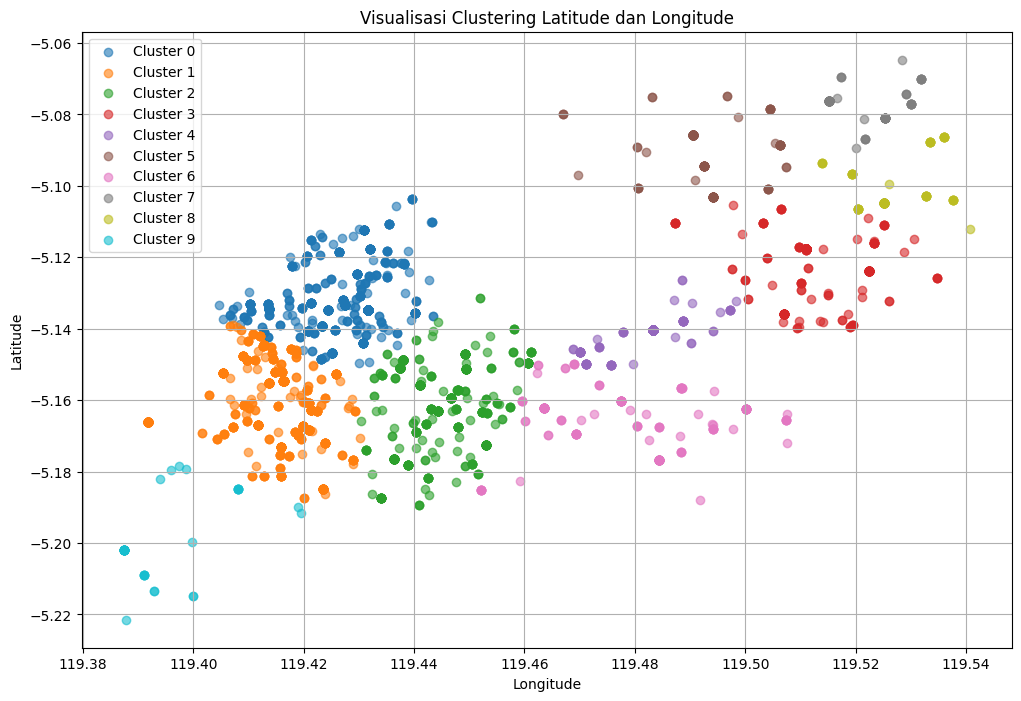

In [38]:
# Visualisasi scatter plot untuk masing-masing cluster
plt.figure(figsize=(12, 8))
for cluster_label in np.unique(locdata['cluster']):
    cluster_data = locdata[locdata['cluster'] == cluster_label]
    plt.scatter(cluster_data['long'], cluster_data['lat'], label=f'Cluster {cluster_label}', alpha=0.6)

plt.title('Visualisasi Clustering Latitude dan Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()


In [39]:
# Menentukan pusat peta
center_lat = locdata['lat'].mean()
center_long = locdata['long'].mean()

# Membuat peta menggunakan Folium
map_clusters = folium.Map(location=[center_lat, center_long], zoom_start=13)

# Warna untuk setiap cluster
colors = itertools.cycle(['blue', 'orange', 'green','red','purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'darkgreen', 'cadetblue', 'darkpurple', 'pink'])

# Menambahkan data ke peta
for cluster_label in np.unique(locdata['cluster']):
    cluster_data = locdata[locdata['cluster'] == cluster_label]
    color = next(colors)
    for _, row in cluster_data.iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['long']],
            radius=5,
            color=color,
            fill=True,
            fill_opacity=0.6,
            popup=f"Cluster: {cluster_label}\nAddress: {row['address']}"
        ).add_to(map_clusters)
map_clusters

# Evaluation with Silhouette Score

In [40]:
# Menghitung Silhouette Score
silhouette_avg = silhouette_score(mslibrary, locdata['cluster'])

# Menampilkan hasil
print(f'Silhouette Score untuk clustering ini: {silhouette_avg:.4f}')


Silhouette Score untuk clustering ini: 0.4919
